In [3]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult

NF_ORANGE = '#ff5a36'
NF_BLUE = '#163251'
cmaps_hex = ['#193251','#FF5A36','#696969', '#7589A2','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [4]:
df = pd.read_pickle('../data/final_dataframe.pkl')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163680 entries, 0 to 163679
Data columns (total 7 columns):
 #   Column                                             Non-Null Count   Dtype         
---  ------                                             --------------   -----         
 0   Date                                               163680 non-null  datetime64[ns]
 1   Photovoltaics [MWh] Original resolutions           163680 non-null  float64       
 2   Photovoltaics [MW] Calculated resolutions          163680 non-null  float64       
 3   Total (grid load) [MWh] Original resolutions       163680 non-null  float64       
 4   Germany/Luxembourg [€/MWh] Calculated resolutions  163680 non-null  float64       
 5   normalisation_factor                               163680 non-null  float64       
 6   Solar_generation_MWh_normalized                    163680 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 8.7 MB


now to make the df a bit easier to work with replce the column names with simpler names 

In [6]:
def col_names(df):
    column_names = {'Photovoltaics [MWh] Original resolutions': 'Solar_generation_MWh',
                'Photovoltaics [MW] Calculated resolutions': 'Solar_installed_MW',
                'Total (grid load) [MWh] Original resolutions': 'Total_consumption_MWh',
                'Germany/Luxembourg [€/MWh] Calculated resolutions': 'DE_LU_price_per_MWh',}
    df.rename(columns=column_names, inplace=True)
    return df

In [7]:
col_names(df)

,Date,Solar_generation_MWh,Solar_installed_MW,Total_consumption_MWh,DE_LU_price_per_MWh,normalisation_factor,Solar_generation_MWh_normalized
0,2018-10-01 00:00:00,0.0,42805.0,10589.75,59.53,0.684015,0.0
1,2018-10-01 00:15:00,0.0,42805.0,10589.75,59.53,0.684015,0.0
2,2018-10-01 00:30:00,0.0,42805.0,10589.75,59.53,0.684015,0.0
3,2018-10-01 00:45:00,0.0,42805.0,10589.75,59.53,0.684015,0.0
4,2018-10-01 01:00:00,0.0,42805.0,10589.75,56.10,0.684015,0.0
...,...,...,...,...,...,...,...
163675,2023-06-01 22:45:00,0.0,62579.0,12945.50,95.41,1.000000,0.0
163676,2023-06-01 23:00:00,0.0,62579.0,12817.75,86.53,1.000000,0.0
163677,2023-06-01 23:15:00,0.0,62579.0,12539.00,86.53,1.000000,0.0
163678,2023-06-01 23:30:00,0.0,62579.0,12371.00,86.53,1.000000,0.0


In [8]:
df.describe()

,Date,Solar_generation_MWh,Solar_installed_MW,Total_consumption_MWh,DE_LU_price_per_MWh,normalisation_factor,Solar_generation_MWh_normalized
count,163680,163680.000000,163680.000000,163680.000000,163680.000000,163680.000000,163680.000000
mean,2021-01-30 11:25:53.753666048,1317.171841,51877.263978,14185.096180,97.992623,0.828988,1584.258910
min,2018-10-01 00:00:00,0.000000,42805.000000,7471.000000,-129.960000,0.684015,0.000000
25%,2019-12-01 04:56:15,0.000000,45435.000000,12179.500000,34.960000,0.726042,0.000000
50%,2021-01-30 10:52:30,13.750000,53538.000000,14128.500000,53.110000,0.855527,16.816748
75%,2022-04-01 17:48:45,2042.750000,58002.000000,16173.750000,119.962500,0.926860,2485.099555
max,2023-06-01 23:45:00,10249.000000,62579.000000,20542.500000,871.000000,1.000000,10770.803678
std,NaN,2073.171930,5898.121075,2455.453971,108.509004,0.094251,2473.386880


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163680 entries, 0 to 163679
Data columns (total 7 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   Date                             163680 non-null  datetime64[ns]
 1   Solar_generation_MWh             163680 non-null  float64       
 2   Solar_installed_MW               163680 non-null  float64       
 3   Total_consumption_MWh            163680 non-null  float64       
 4   DE_LU_price_per_MWh              163680 non-null  float64       
 5   normalisation_factor             163680 non-null  float64       
 6   Solar_generation_MWh_normalized  163680 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 8.7 MB


<Axes: xlabel='Date', ylabel='Solar_generation_MWh_normalized'>

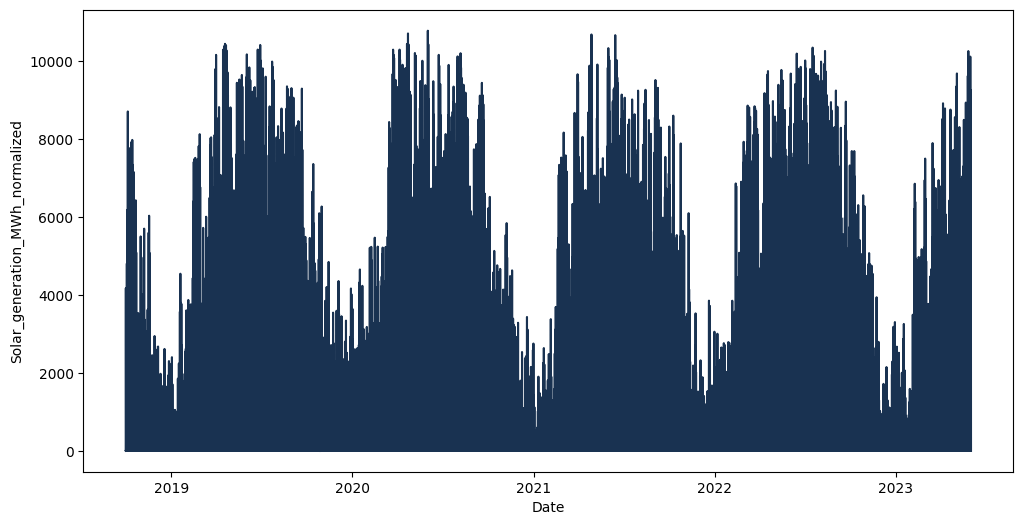

In [10]:
sns.lineplot(df, y="Solar_generation_MWh_normalized", x="Date")

<Axes: >

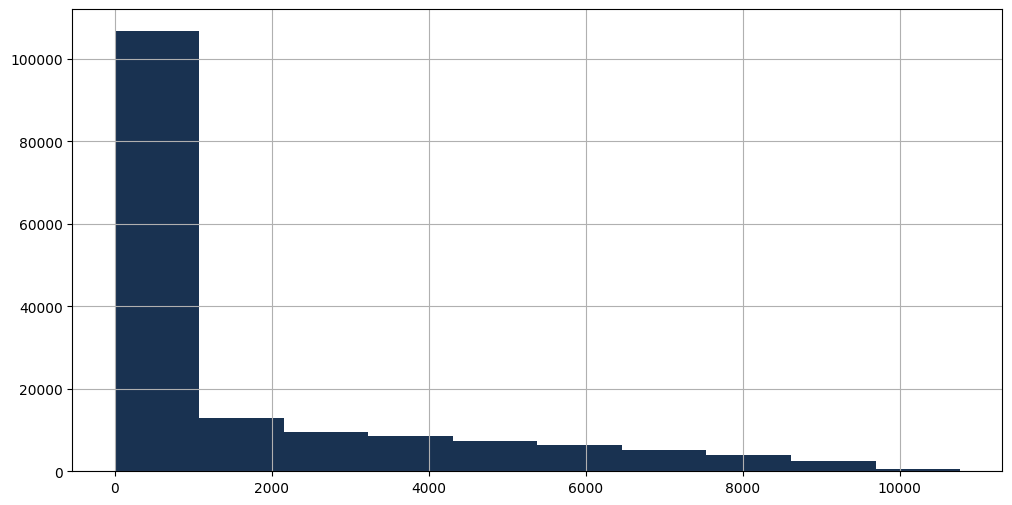

In [11]:
df['Solar_generation_MWh_normalized'].hist()

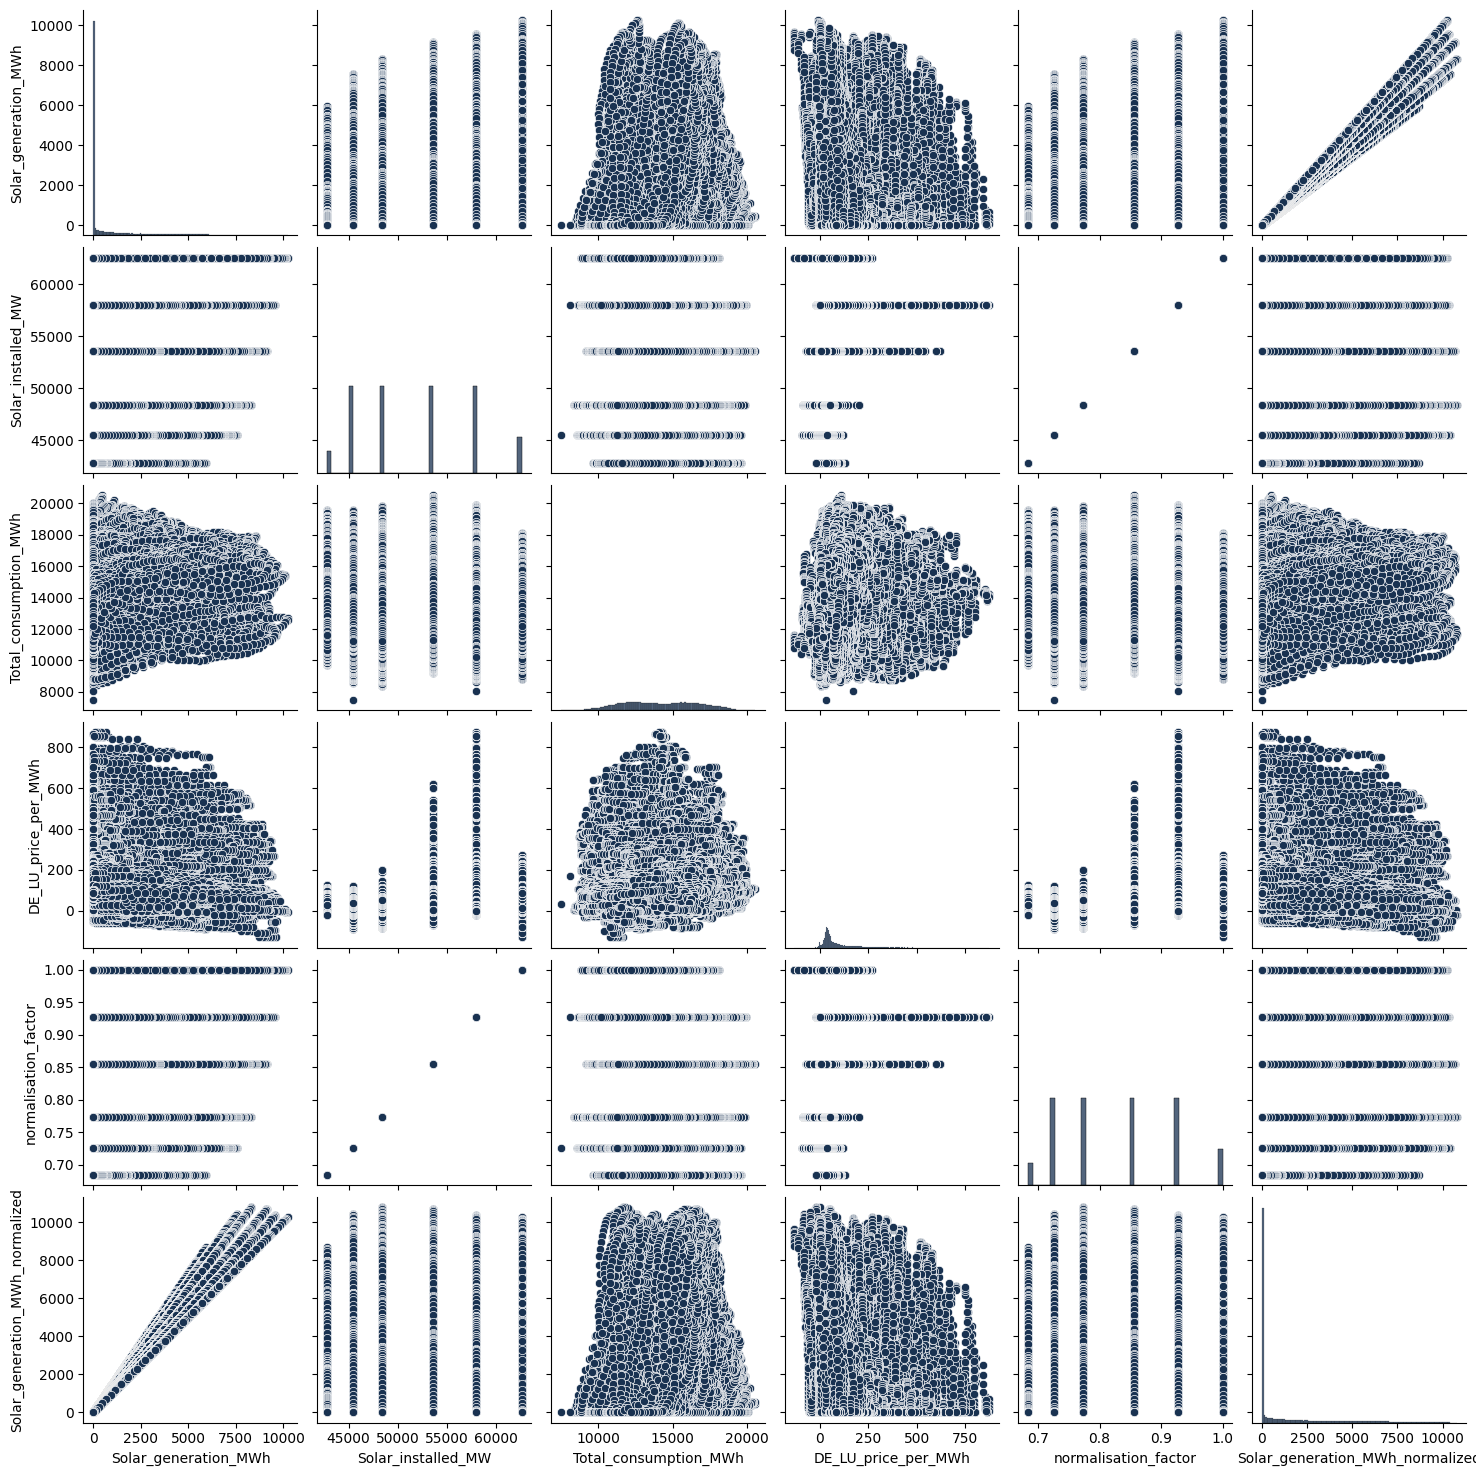

In [12]:
sns.pairplot(df)

Clear correlation between the correlated features (normalization factor, solar installed and normalized solar)
Interestingly the price shows no real correlation to the solar generation  

In [13]:
#%pip install pmdarima==2.0.3


In [14]:
import requests
import csv
from itertools import permutations
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

#from pmdarima.arima import auto_arima
import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing


###Let's explore the data a bit more

maybe we can find additional patterns to our daily pattern (96) and the yearly pattern (96* 365.25(average days per year))

In [15]:
solar = df.copy()
solar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163680 entries, 0 to 163679
Data columns (total 7 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   Date                             163680 non-null  datetime64[ns]
 1   Solar_generation_MWh             163680 non-null  float64       
 2   Solar_installed_MW               163680 non-null  float64       
 3   Total_consumption_MWh            163680 non-null  float64       
 4   DE_LU_price_per_MWh              163680 non-null  float64       
 5   normalisation_factor             163680 non-null  float64       
 6   Solar_generation_MWh_normalized  163680 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 8.7 MB


I want to see if we have addtional seasonal patterns beside the yeary one, therfore I will plot several smoothed plots 

In [16]:
solar = solar.assign(
    timestamp = lambda x: pd.to_datetime(x['Date']), 
    date = lambda x: x['timestamp'].dt.date,
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    dayofyear = lambda x: x['timestamp'].dt.dayofyear,
    hour = lambda x: x['timestamp'].dt.hour,
)

solar.head()

,Date,Solar_generation_MWh,Solar_installed_MW,Total_consumption_MWh,DE_LU_price_per_MWh,normalisation_factor,Solar_generation_MWh_normalized,timestamp,date,year,month,day,dayofyear,hour
0,2018-10-01 00:00:00,0.0,42805.0,10589.75,59.53,0.684015,0.0,2018-10-01 00:00:00,2018-10-01,2018,10,1,274,0
1,2018-10-01 00:15:00,0.0,42805.0,10589.75,59.53,0.684015,0.0,2018-10-01 00:15:00,2018-10-01,2018,10,1,274,0
2,2018-10-01 00:30:00,0.0,42805.0,10589.75,59.53,0.684015,0.0,2018-10-01 00:30:00,2018-10-01,2018,10,1,274,0
3,2018-10-01 00:45:00,0.0,42805.0,10589.75,59.53,0.684015,0.0,2018-10-01 00:45:00,2018-10-01,2018,10,1,274,0
4,2018-10-01 01:00:00,0.0,42805.0,10589.75,56.10,0.684015,0.0,2018-10-01 01:00:00,2018-10-01,2018,10,1,274,1


In [17]:
solar.set_index(solar['Date'], inplace=True)

ValueError: cannot reindex on an axis with duplicate labels

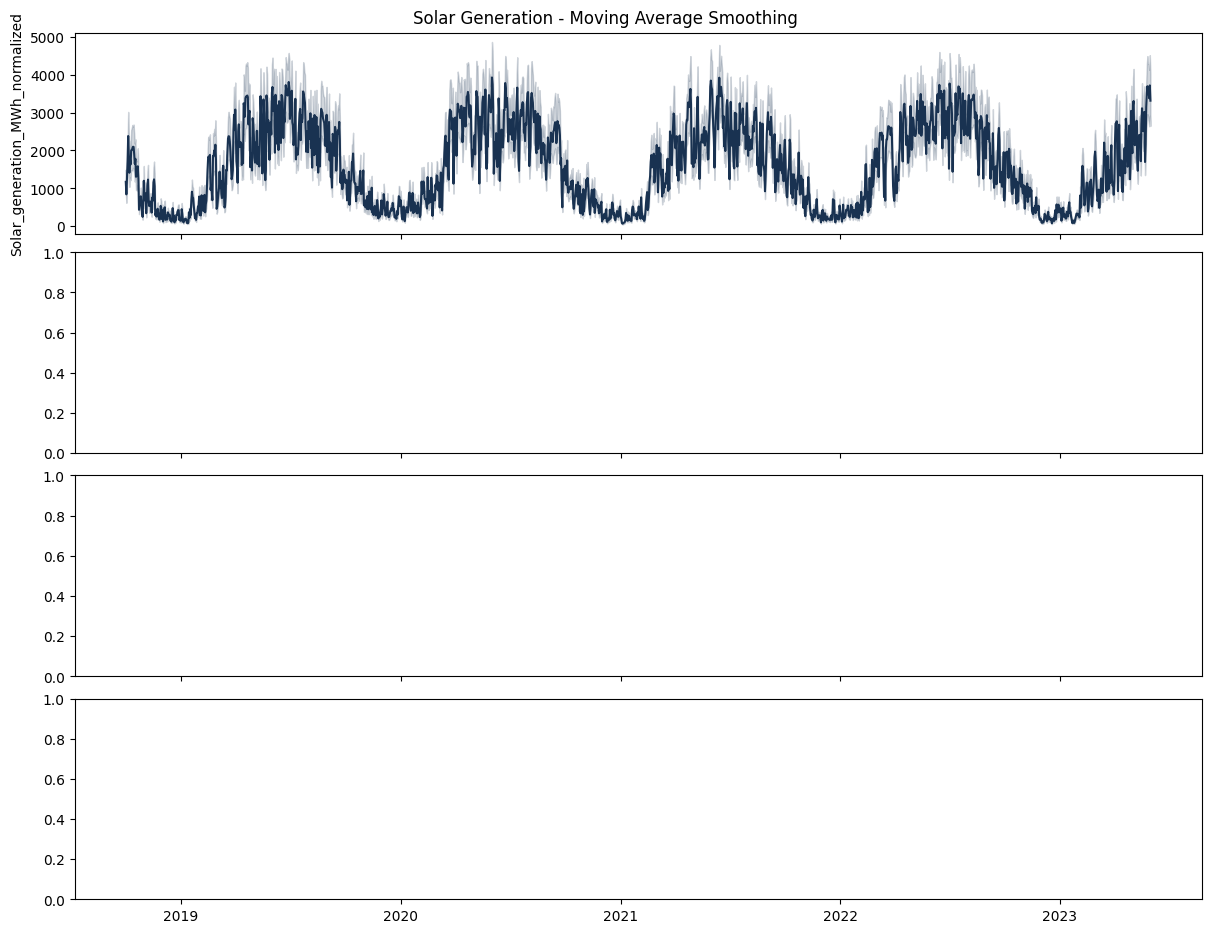

In [23]:
# Plot moving average of different length (week, month, year)
ma = [7, 30, 365]


smooth_daily_data_df = solar.copy()
# daily_data_df \ .reset_index() \ .assign(date = lambda x: x['Date'].transform(pd.to_datetime))

# Smooth and plot
fig, ax = plt.subplots(len(ma)+1, 1, figsize=(12, 9), constrained_layout=True, sharex=True)
plt.suptitle('Solar Generation - Moving Average Smoothing', y=1.02);

for i, m in enumerate(ma):
    smooth_daily_data_df[f'pv_smooth_ma_{m}'] = smooth_daily_data_df['Solar_generation_MWh_normalized'].rolling(window=m,center=True).mean() #compute the rolling mean

    sns.lineplot(x='date', y='Solar_generation_MWh_normalized', data=smooth_daily_data_df,  ax=ax[i])
    sns.lineplot(x='date', y=f'pv_smooth_ma_{m}', label=f'PV smoothed:\n ma = {m} days', data=smooth_daily_data_df, color=NF_ORANGE, ax=ax[i])

    ax[i].legend(title='', loc='center left', bbox_to_anchor=(1, 0.5))
    ax[i].set(title='', ylabel='[MWh]');
        
sns.lineplot(x='date', y=f'pv_smooth_ma_{m}', label=f'PV smoothed:\n ma = {m} days', data=smooth_daily_data_df, color=NF_BLUE, ax=ax[i+1])
ax[i+1].legend(title='', loc='center left', bbox_to_anchor=(1, 0.5))
ax[i+1].set(title='', ylabel='[MWh]');

    
#fig.savefig("visualisations/Basel_Temp_MA_Smoothing.png",dpi=300)

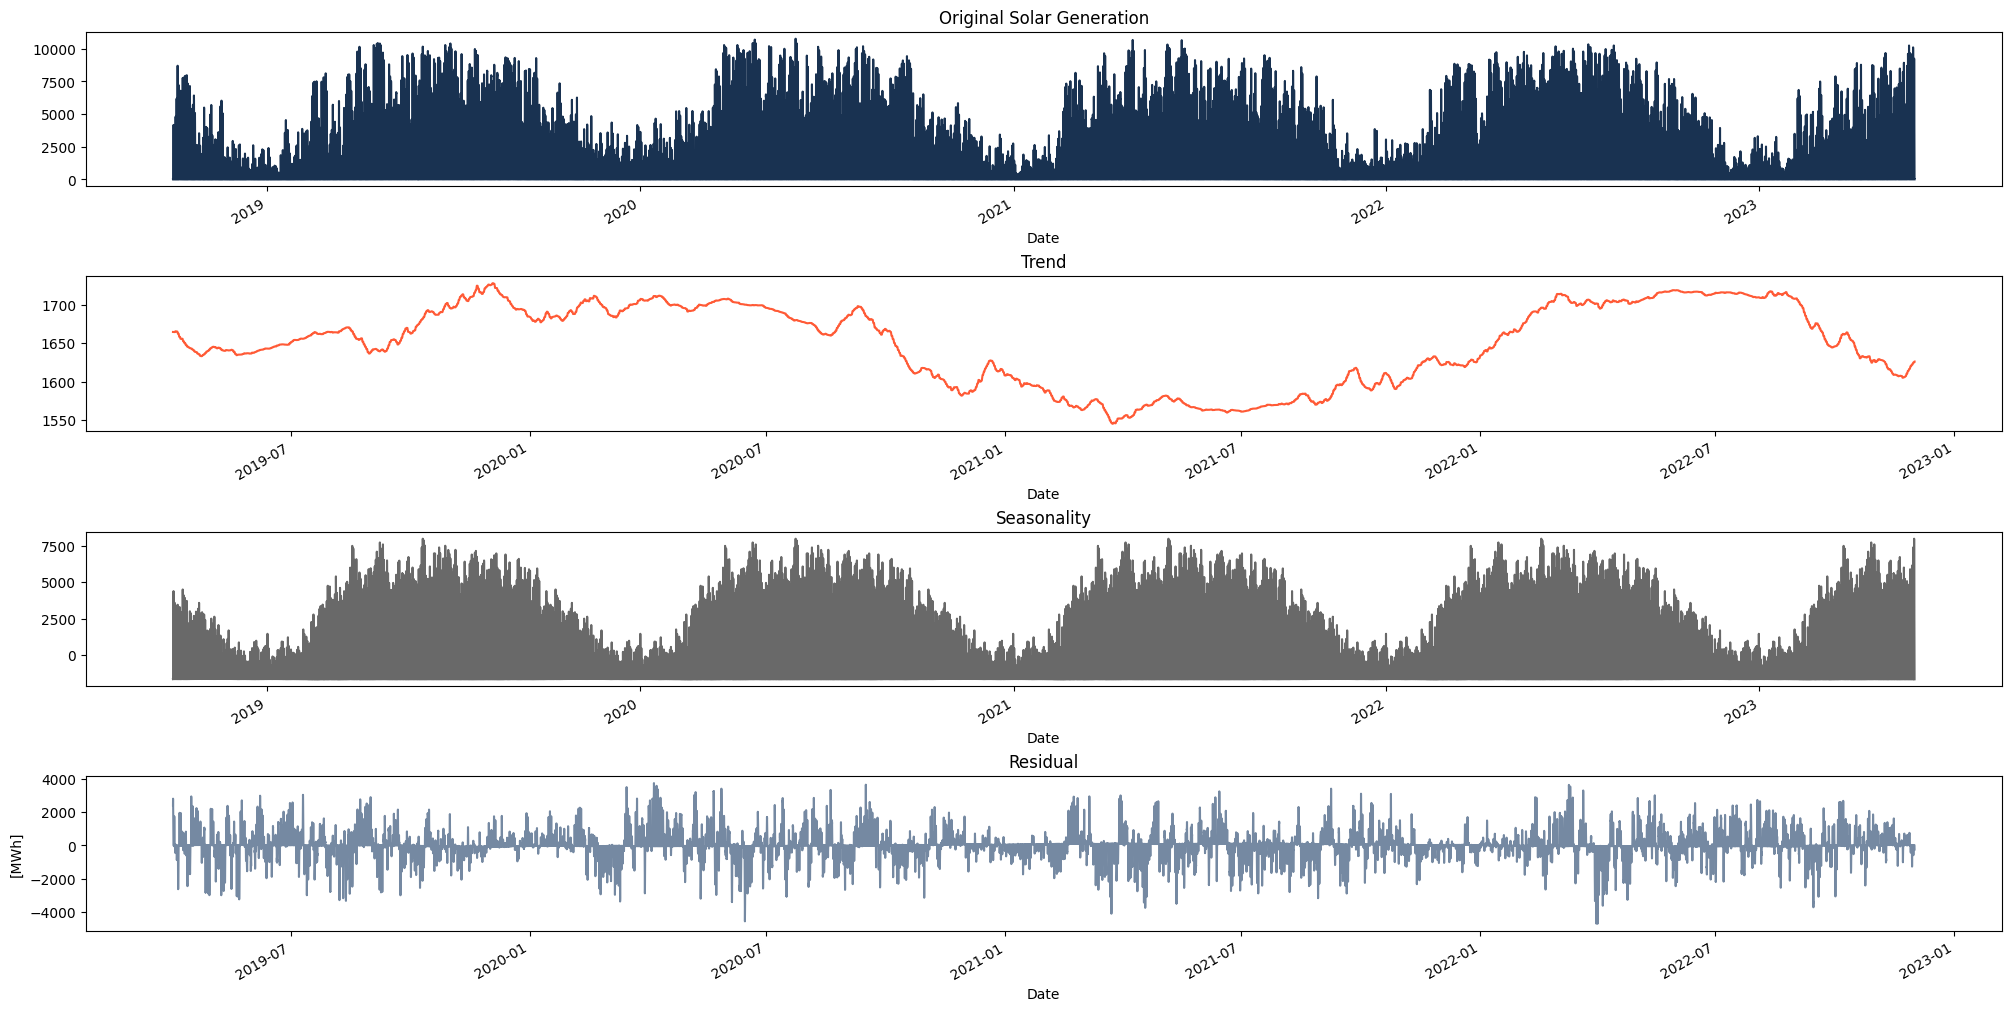

In [ ]:
# Check decomposition of trend, seasonality and residue of original time series
decomposition = seasonal_decompose(x=solar['Solar_generation_MWh_normalized'], 
                                   model='additive',
                                   period=35040)


fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='Original Solar Generation')
plt.ylabel("[MWh]")
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='Trend')
plt.ylabel("[MWh]")
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='Seasonality')
plt.ylabel("[MWh]")
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='Residual')
plt.ylabel("[MWh]")
fig.set_size_inches(20, 10);

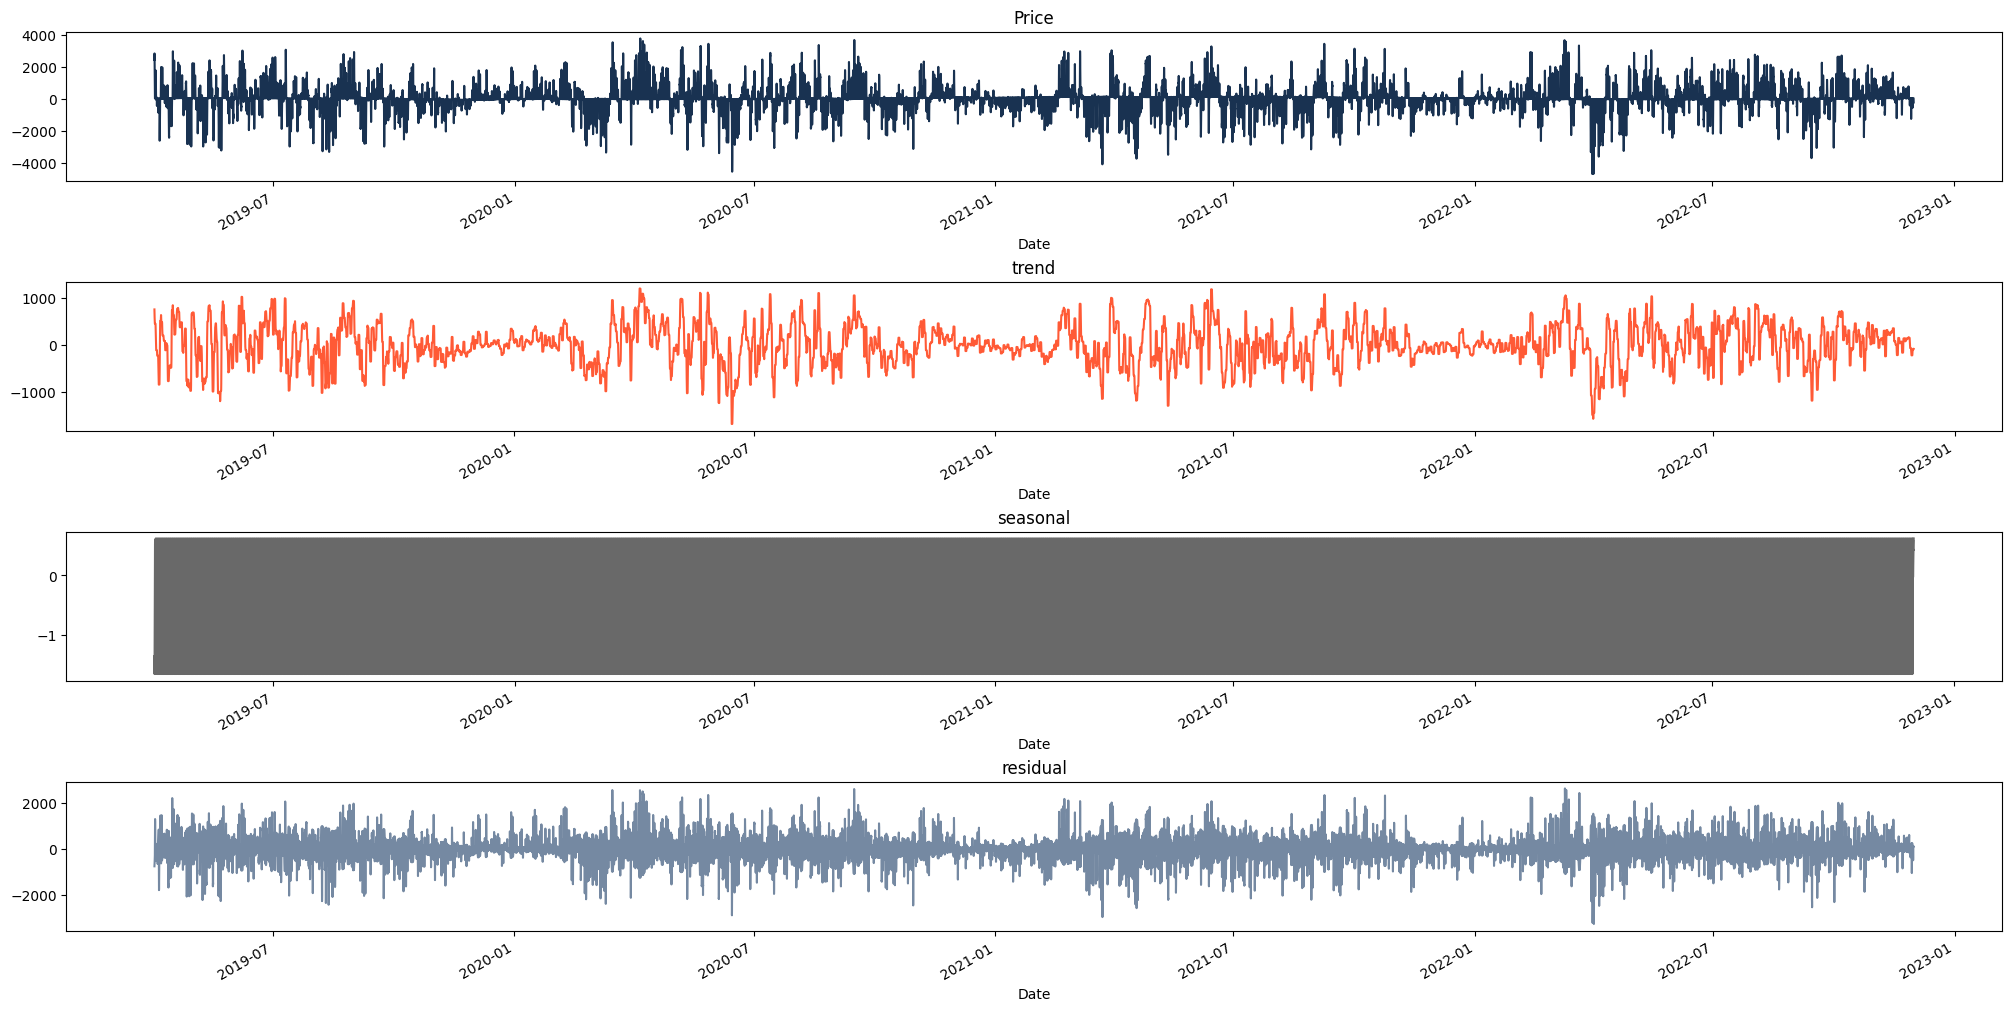

In [ ]:
# Check decomposition of trend, seasonality and residue of original time series
decomposition_2 = seasonal_decompose(x=decomposition.resid.dropna(), 
                                   model='additive',
                                   period=96)


fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition_2.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='Price')
decomposition_2.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition_2.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition_2.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

In [ ]:
# Lets start decomposing the data 

# Check decomposition of trend, seasonality and residue of original time series
decomposition = seasonal_decompose(x=df['Solar_generation_MWh_normalized'], 
                                   model='additive',  # Why multiplicative and not additive? additive only with constant patterns, multiplicative variing pattern 
                                    period = 35064 )# 15 min/day * 365.25 days per year = 35064 observations in each cycle)

<Axes: xlabel='Date', ylabel='Solar_generation_MWh_normalized'>

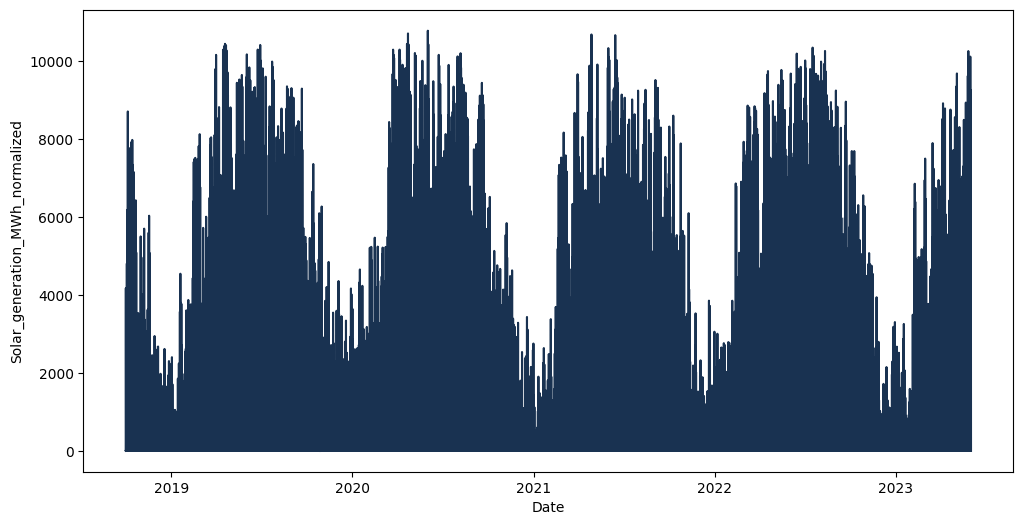

In [ ]:
sns.lineplot(decomposition.observed)

<Axes: xlabel='Date', ylabel='trend'>

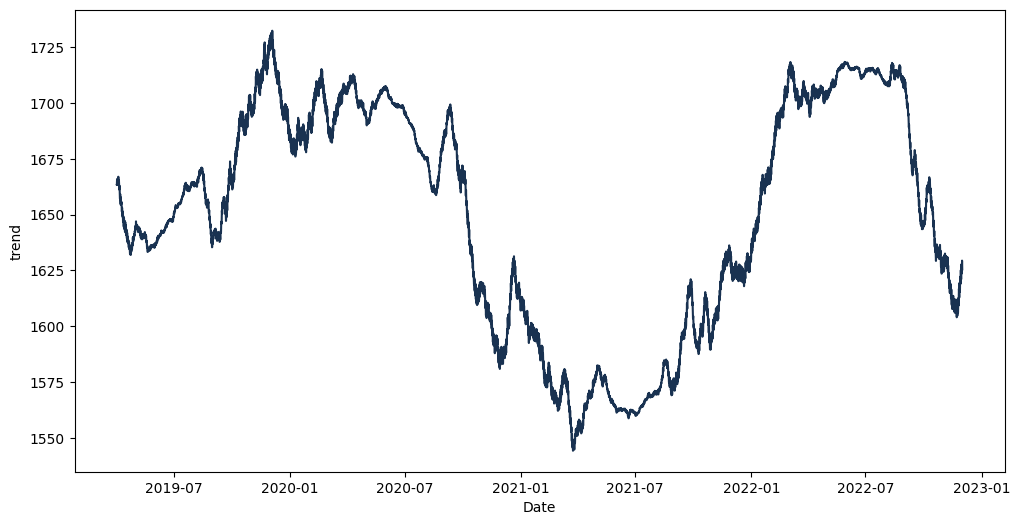

In [ ]:
sns.lineplot(decomposition.trend)

### Observation for period= 96:
The trend pattern looked like a seasonality pattern it might have something to do with the period set in the decompose method. My thinking behind it was that we measure every 15 min each day therefore we have 96 observations in each cycle/ day but that might be wrong. So I will look deeper into the period parameter of the function and figure out what the problem is here. 

### Observations for period= 35064 ###
Looks much better and very much like I would have expected the trend and seasonality to look like

<Axes: xlabel='Date', ylabel='seasonal'>

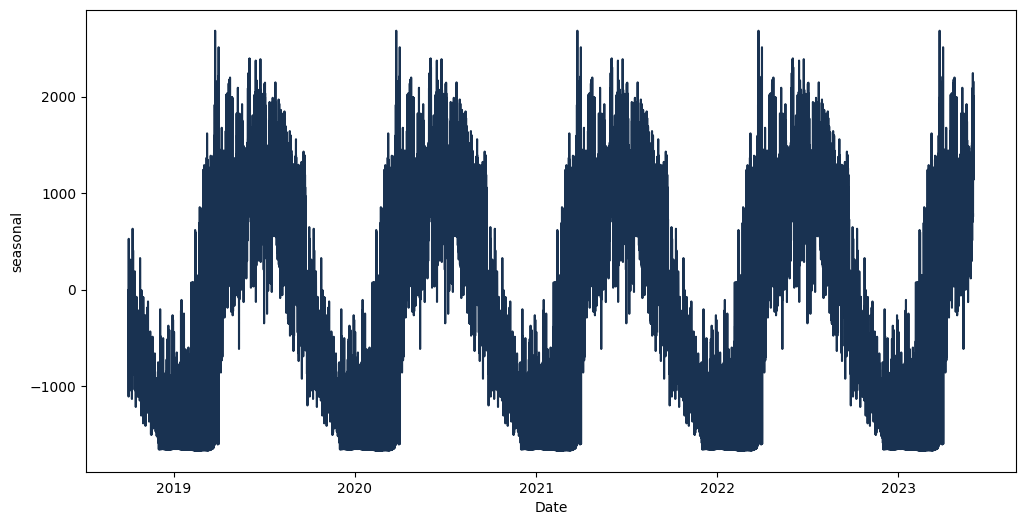

In [ ]:
sns.lineplot(decomposition.seasonal)

<Axes: xlabel='Date', ylabel='resid'>

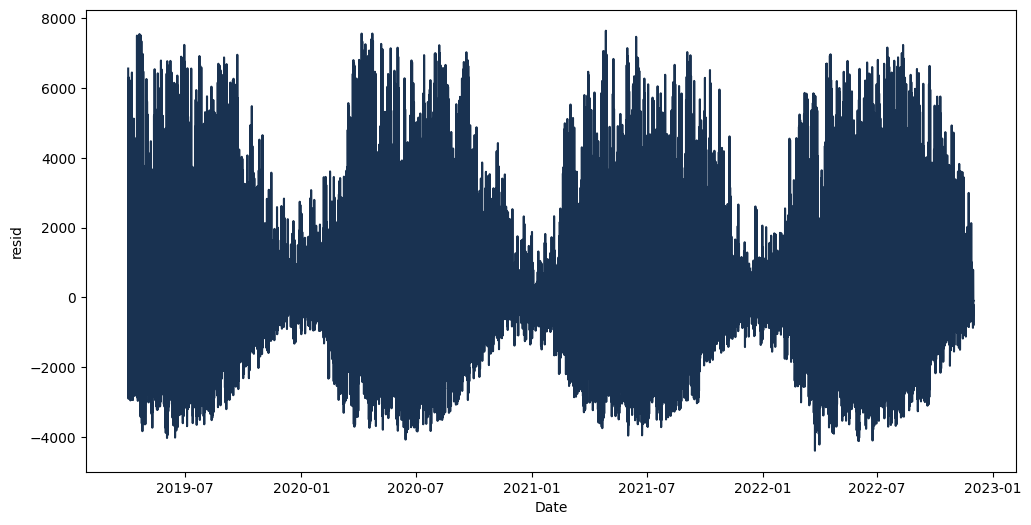

In [ ]:
sns.lineplot(decomposition.resid)

In [ ]:
decomposition.resid

Date
2018-10-01 00:00:00   NaN
2018-10-01 00:15:00   NaN
2018-10-01 00:30:00   NaN
2018-10-01 00:45:00   NaN
2018-10-01 01:00:00   NaN
                       ..
2023-06-01 22:45:00   NaN
2023-06-01 23:00:00   NaN
2023-06-01 23:15:00   NaN
2023-06-01 23:30:00   NaN
2023-06-01 23:45:00   NaN
Name: resid, Length: 163680, dtype: float64

### Short Summary ###
the residuals are probably not stationary there is in my opinion still quite some seasonality in there let's check that briefly

In [ ]:
def testing_stationarity(univariate):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = univariate.rolling(35064).mean()
    rolling_std_dev = univariate.rolling(35064).std()
    
    # Plot the statistics
    sns.lineplot(univariate, label='Original Time Series')
    sns.lineplot(rolling_mean,  label='Rolling Mean')
    sns.lineplot(rolling_std_dev,  label = 'Rolling Std Dev')
    plt.show()



    kpss_test = kpss(univariate, regression='c', nlags="legacy", store=False)
    adf_test = adfuller(univariate, autolag='AIC')
    
    # ADF test
    print("ADF Test:")
    print('Null Hypothesis: Not Stationary')
    print(f'ADF Statistic:{ adf_test[0]} \n p-value: {adf_test[1]}')
    print('----'*10)
    
    # KPSS test
    print(f'KPSS Test:{kpss_test}')
    print(f'Null Hypothesis: Stationary \n KPSS Statistic: {kpss_test[0]} \n KPSS p-value: {kpss_test[1]}')
    print('----'*10)

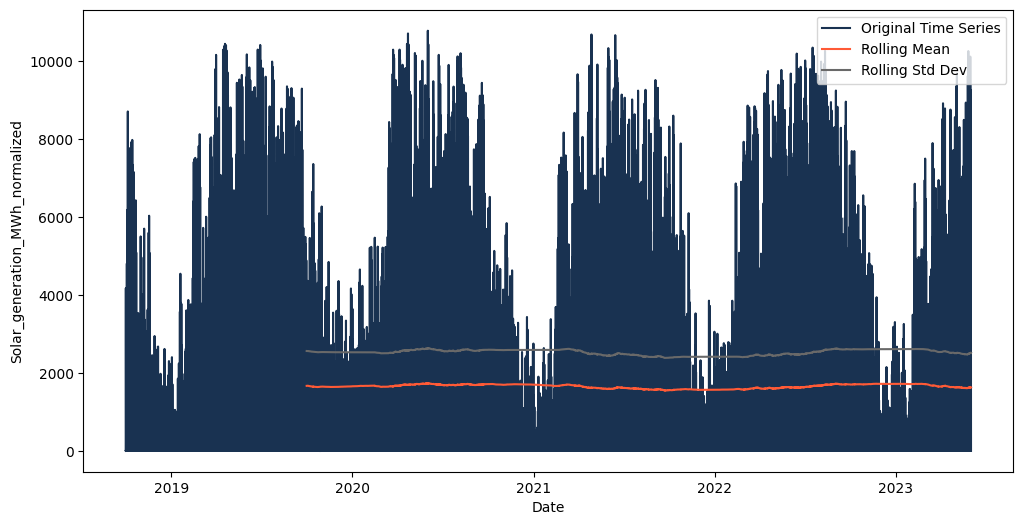

/var/folders/vh/9svjskkn54n5t04bltkc_8fw0000gn/T/ipykernel_8991/1156347331.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(univariate, regression='c', nlags="legacy", store=False)


ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic:-7.727262864753442 
 p-value: 1.1501642242152454e-11
----------------------------------------
KPSS Test:(2.1699998532704, 0.01, 77, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
Null Hypothesis: Stationary 
 KPSS Statistic: 2.1699998532704 
 KPSS p-value: 0.01
----------------------------------------


In [ ]:
testing_stationarity(df['Solar_generation_MWh_normalized'])

It is stationary:
- testing for non-stationarity is significant so we can assume the oposite it is stationary 
- the stationarity test however is slightly significant so we will detrend our data a bit more 

In [ ]:
# Let's try to detrend it further by taking a second seasonality into account the daily cycle
df['Solar_detrend'] = (df['Solar_generation_MWh_normalized'] - df['Solar_generation_MWh_normalized'].shift(96))

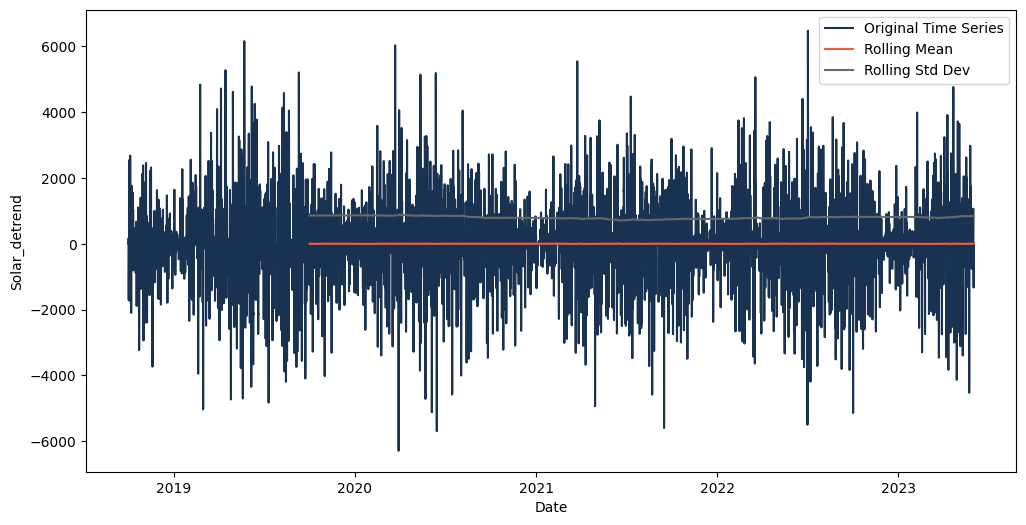

/var/folders/vh/9svjskkn54n5t04bltkc_8fw0000gn/T/ipykernel_8991/1156347331.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(univariate, regression='c', nlags="legacy", store=False)


ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic:-48.9886682951004 
 p-value: 0.0
----------------------------------------
KPSS Test:(0.00576408605033083, 0.1, 77, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
Null Hypothesis: Stationary 
 KPSS Statistic: 0.00576408605033083 
 KPSS p-value: 0.1
----------------------------------------


In [ ]:
testing_stationarity(df['Solar_detrend'].dropna()) # we shifted everything by a year so we obtain a lot of nas which cannot be used for testing. 

The KPSS test look much better now and is not significant anymore. Lets work with that from now on 

### Short Summary
No surprise but there are clearly several seasonality patterns in the data. Let's find out which model to use to handle this data. 
Test first MSTL for multiseasonality decomposition

In [ ]:
mstl = MSTL(df["Solar_generation_MWh_normalized"], periods=[24 * 4 ])
res = mstl.fit()

In [ ]:
res.seasonal.head()

In [ ]:
ax = res.plot()

### Let's do the train test split
for now I will just split the data into old and new data and us the new data for the testing split 

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df['Solar_generation_MWh_normalized'], test_size=.2, shuffle=False)

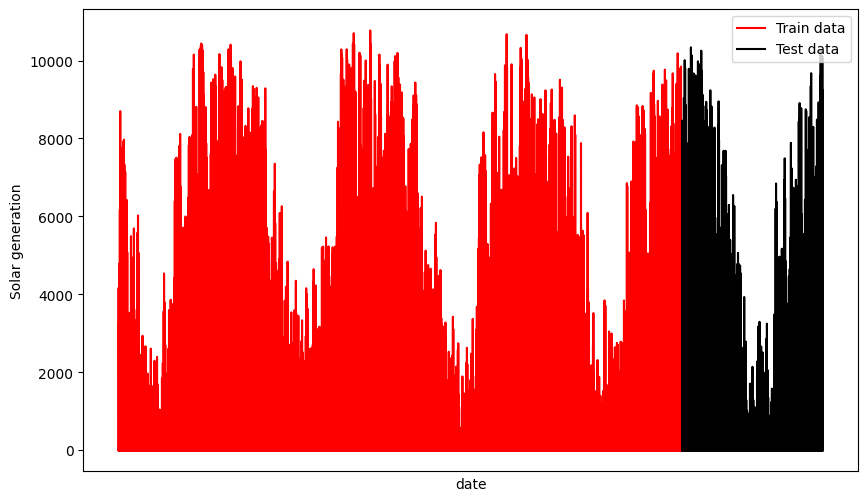

In [ ]:
# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.xlabel('date')
plt.ylabel('Solar generation')
plt.xticks([])
plt.plot(train, 'red', label='Train data')
plt.plot(test, 'black', label='Test data')
plt.legend();

## Small univariate arima model ##